# Beer style prediction - GPU model experimentation

## Set up environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import modules
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import dump
from joblib import load
from pandas_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.nn import functional as F

In [3]:
os.getcwd()

'/content'

In [4]:
os.chdir('./drive/My Drive/ADSI/adsi_at2')
os.getcwd()

'/content/drive/My Drive/ADSI/adsi_at2'

## Get data

In [5]:
# Load magic command for auto-reloading external modules
%load_ext autoreload
%autoreload 2

In [6]:
from src.data.sets import load_sets
X_train, y_train, X_val, y_val, X_test, y_test = load_sets(path='./data/processed/')

In [7]:
# Import PytorchDataset class and convert all sets
from src.models.pytorch import PytorchDataset
train_dataset = PytorchDataset(X=X_train, y=y_train)
val_dataset = PytorchDataset(X=X_val, y=y_val)
test_dataset = PytorchDataset(X=X_test, y=y_test)

## Define architecture

In [8]:
# Instantiate PytorchMultiClass with the correct number of input feature and save it into a variable called model
class PytorchMultiClass(nn.Module):
    def __init__(self, num_features):
        super(PytorchMultiClass, self).__init__()
        
        self.layer_1 = nn.Linear(num_features, 1024)
        self.layer_2 = nn.Linear(1024, 512)
        self.layer_3 = nn.Linear(512, 128)
        self.layer_4 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, 104) 
        self.softmax = nn.Softmax(dim=1)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        self.batchnorm_1 = nn.BatchNorm1d(1024)
        self.batchnorm_2 = nn.BatchNorm1d(512)
        self.batchnorm_3 = nn.BatchNorm1d(128)
        self.batchnorm_4 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm_1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm_2(x)
        x = self.relu(x)
        
        x = self.layer_3(x)
        x = self.batchnorm_3(x)
        x = self.relu(x)

        x = self.layer_4(x)
        x = self.batchnorm_4(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return self.softmax(x)


model = PytorchMultiClass(X_train.shape[1])

In [9]:
# Set model to use the device available
from src.models.pytorch import get_device
device = get_device()
model.to(device)

PytorchMultiClass(
  (layer_1): Linear(in_features=18, out_features=1024, bias=True)
  (layer_2): Linear(in_features=1024, out_features=512, bias=True)
  (layer_3): Linear(in_features=512, out_features=128, bias=True)
  (layer_4): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=104, bias=True)
  (softmax): Softmax(dim=1)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (batchnorm_1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [10]:
# Check device
device

device(type='cuda', index=0)

## Train model

In [11]:
# Instantiate a nn.CrossEntropyLoss() and save it into a variable called criterion
criterion = nn.CrossEntropyLoss()

In [12]:
# Instantiate a torch.optim.Adam() optimizer with the model's parameters and learning rate and save it into a variable called optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [13]:
# Import train_classification and test_classification functions that will perform forward and back propagation and calculate loss and Accuracy scores
from src.models.pytorch import train_classification, test_classification

In [14]:
# Define N_EPOCHS and BATCH_SIZE variables
N_EPOCHS = 50
BATCH_SIZE = 512

In [15]:
train_loss_history = [] 
train_acc_history = []
valid_loss_history = []
valid_acc_history = []

In [16]:
# Create a for loop that will iterate through the specified number of epochs and will train the model with the training set and assess the performance on the validation set and print their scores
for epoch in range(N_EPOCHS):
    train_loss, train_acc = train_classification(train_dataset, model=model, criterion=criterion, optimizer=optimizer, batch_size=BATCH_SIZE, device=device)
    valid_loss, valid_acc = test_classification(val_dataset, model=model, criterion=criterion, batch_size=BATCH_SIZE, device=device)

    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    valid_loss_history.append(valid_loss)
    valid_acc_history.append(valid_acc)
    
    print(f'Epoch: {epoch}')
    print(f'\t(train)\t|\tLoss: {train_loss:.4f}\t|\tAcc: {train_acc * 100:.1f}%')
    print(f'\t(valid)\t|\tLoss: {valid_loss:.4f}\t|\tAcc: {valid_acc * 100:.1f}%')

Epoch: 0
	(train)	|	Loss: 0.0089	|	Acc: 13.6%
	(valid)	|	Loss: 0.0088	|	Acc: 17.9%
Epoch: 1
	(train)	|	Loss: 0.0087	|	Acc: 19.8%
	(valid)	|	Loss: 0.0087	|	Acc: 21.3%
Epoch: 2
	(train)	|	Loss: 0.0087	|	Acc: 21.8%
	(valid)	|	Loss: 0.0087	|	Acc: 22.4%
Epoch: 3
	(train)	|	Loss: 0.0087	|	Acc: 22.6%
	(valid)	|	Loss: 0.0087	|	Acc: 22.9%
Epoch: 4
	(train)	|	Loss: 0.0087	|	Acc: 23.0%
	(valid)	|	Loss: 0.0086	|	Acc: 23.4%
Epoch: 5
	(train)	|	Loss: 0.0086	|	Acc: 23.5%
	(valid)	|	Loss: 0.0086	|	Acc: 23.8%
Epoch: 6
	(train)	|	Loss: 0.0086	|	Acc: 23.8%
	(valid)	|	Loss: 0.0086	|	Acc: 24.0%
Epoch: 7
	(train)	|	Loss: 0.0086	|	Acc: 24.0%
	(valid)	|	Loss: 0.0086	|	Acc: 24.1%
Epoch: 8
	(train)	|	Loss: 0.0086	|	Acc: 24.2%
	(valid)	|	Loss: 0.0086	|	Acc: 24.3%
Epoch: 9
	(train)	|	Loss: 0.0086	|	Acc: 24.3%
	(valid)	|	Loss: 0.0086	|	Acc: 24.3%
Epoch: 10
	(train)	|	Loss: 0.0086	|	Acc: 24.4%
	(valid)	|	Loss: 0.0086	|	Acc: 24.4%
Epoch: 11
	(train)	|	Loss: 0.0086	|	Acc: 24.5%
	(valid)	|	Loss: 0.0086	|	Acc: 24.6%
Ep

### Resume training from checkpoint (if required)

In [17]:
# Save model checkpoint
torch.save({ 
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss,
            }, "./models/checkpoints/beer_pred.pt")

In [49]:
# Load model from checkpoint
model = PytorchMultiClass(X_train.shape[1])
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

checkpoint = torch.load("./models/checkpoints/beer_pred.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

#model.eval() # OR
model.train()

PytorchMultiClass(
  (layer_1): Linear(in_features=18, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=128, bias=True)
  (layer_4): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=104, bias=True)
  (softmax): Softmax(dim=1)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm_1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

## Assess performance

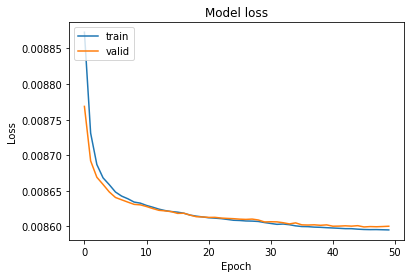

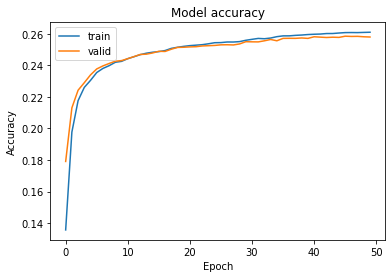

In [19]:
# Plot training and validation loss and accuracy per epoch
# Adapted from https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

%matplotlib inline

plt.plot(train_loss_history)
plt.plot(valid_loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

plt.plot(train_acc_history)
plt.plot(valid_acc_history)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [20]:
# Assess the model performance on the testing set and print its scores
test_loss, test_acc = test_classification(test_dataset, model=model, criterion=criterion, batch_size=BATCH_SIZE, device=device)
print(f'\tLoss: {test_loss:.4f}\t|\tAcc: {test_acc:.1f}')

	Loss: 0.0086	|	Acc: 0.3


## Save artefacts for deployment

In [22]:
# Save the model into the models folder
torch.save(model, "./models/beer_pred_colab.pt")
torch.save(model.state_dict(), "./models/beer_pred_colab_state_dict.pt")